# Milestones 1 & 2 & 3<a id='top'></a>


### Dataset

SECOM manufacturing Data Set from the UCI Machine Learning Repository
https://archive.ics.uci.edu/ml/machine-learning-databases/secom/

The dataset consists of two files:
1. a dataset file <a href='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'>SECOM</a> containing 1567 examples, each with 591 features, 104 fails
2. a <a href='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'>labels</a> file listing the classifications and date time stamp for each example

The dataset represents a selection of features where 
each example represents a single production entity with associated measured 
features and the labels represent a simple pass/fail yield for in house line 
testing and associated date time stamp.

-1 corresponds to a pass and 1 corresponds to a fail and the data time stamp is for that specific test 
point.

Null values are represented by the 'NaN' value.

## Milestone 1 Instructions

Assume the 591 attributes represent different sensors readings across the manufacturing process. 

Using the <a href='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'>SECOM dataset</a>, create a new notebook, and perform each of the following tasks and answer the related questions:

1. Refine your data understanding and prepare a DFD of solving the manufacturing quality problem
2. Read and merge data
3. Clean and prepare data 
4. Visually explore data
5. Handle class imbalance problem
6. Apply feature selection techniques to reduce dimensionality of data
7. What are your initial findings? Describe them in a [summary](#summary1) section

## Milestone 2 Instructions

1. Split prepared data from Milestone 1 into training and testing
2. Build a <b>decision tree</b> model that detects faulty products
3. Build an <b>ensemble model</b> that detects faulty products
4. Build an <b>SVM</b> model
5. Evaluate all three models
6. Describe your [findings](#summary2)

## Milestone 3 Instructions

1. Build a simple neural networks model - see the [SLP section](#slp) 
2. Build a DNN model - see the [MLP section](#mlp)
3. Build a RNN model - see the [RNN section](#rnn)
4. Summarize your findings with examples. Explain what the manufacturer should focus on to optimize the manufacturing process - see the [Summary section](#summary3)

In [1]:
# Uncomment the following line to run
# !pip install mlxtend
# !pip install imblearn

In [2]:
import pandas as pd
import numpy as np

from itertools import combinations
from collections import Counter

from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE  # Recursive Feature Elimination
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import svm

from imblearn.over_sampling import SMOTE 

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Data Flow Diagram

![PFD](pfd.png)

## Read and merge data

In [3]:
url_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
url_labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'

local_path_data = './secom.data'
local_path_labels = './secom_labels.data'

def load_data(a_url, path):
    """Return a DataFrame containing a dataset from url or local path."""
    print('Trying to load the data set from a local file if it exists...')
    try:
        data_set = pd.read_csv(path, sep = ' ', header = None)
    except FileNotFoundError:
        print('\tFile not found, loading from Internet...')
        data_set = pd.read_csv(a_url, sep = ' ', header = None)
        print('\t\tData loaded from url')
    else:
        print('\tData loaded from local file')
    
    return data_set

data = load_data(url_data, local_path_data)
labels = load_data(url_labels, local_path_labels)

Trying to load the data set from a local file if it exists...
	Data loaded from local file
Trying to load the data set from a local file if it exists...
	Data loaded from local file


In [4]:
print(data.shape)
data.head(2)

(1567, 590)


,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.006,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.006,208.2045


In [5]:
print(labels.shape)
labels.head(2)

(1567, 2)


,0,1
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00


<b>Merge data and labels</b>

In [6]:
production_df = data
# production_df['timestamp'] = labels[1]  # DO I NEED THE TIMESTAMP?
production_df['outcome'] = labels[0]
print('The size of the dataframe, rows by columns:')
print(production_df.shape)
production_df.head(3)

The size of the dataframe, rows by columns:
(1567, 591)


,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,outcome
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1


## Clean and prepare data

<b>Split the dataset 80/20 into:</b> 

| 80% of records        | 20% of records      |
|-----------------------|---------------------|
| training data X dataframe | test data XX dataframe |
| training label Y array   | test label YY array |


In [7]:
y_prod = production_df.loc[:, 'outcome'].values.astype(str)
x_prod = production_df.drop('outcome', axis = 1)
X, XX, Y, YY = train_test_split(x_prod,
                                y_prod,
                                train_size = 0.8,
                                test_size = 0.2,
                                random_state = 0)

### Replace -1 (indicating a pass) with 0 in the target variable

In [8]:
# TRY THIS
# tdf['Sex'] = tdf['Sex'].map({'male': 0, 'female': 1})

In [9]:
# Distribution of positive and negative cases in the train and test data
Y = Y.astype(int)
mask_neg_outcome = (Y == -1)  # --> bool array
pos_outcome  = (Y == 1)
print('Distribution of pass/fail labels in the training set')
print('Pass labels -1:', sum(mask_neg_outcome), 'cases')
print('Fail labels 1:', sum(pos_outcome), 'cases')

Distribution of pass/fail labels in the training set
Pass labels -1: 1162 cases
Fail labels 1: 91 cases


In [10]:
# Replace -1 with 0 in the train label Y array
Y[mask_neg_outcome] = 0
zero_outcome = (Y == 0)
pos_outcome  = (Y == 1)
print('Pass labels 0:', sum(zero_outcome), 'cases')
print('Fail labels 1:', sum(pos_outcome), 'cases')

Pass labels 0: 1162 cases
Fail labels 1: 91 cases


In [11]:
YY = YY.astype(int)
mask_neg_outcome = (YY == -1)  # --> bool array
pos_outcome  = (YY == 1)
print('Distribution of pass/fail labels in the testing set')
print('Pass labels -1:', sum(mask_neg_outcome), 'cases')
print('Fail labels 1:', sum(pos_outcome), 'cases')

Distribution of pass/fail labels in the testing set
Pass labels -1: 301 cases
Fail labels 1: 13 cases


In [12]:
# Replace -1 with 0 in the test label YY array
YY[mask_neg_outcome] = 0
zero_outcome = (YY == 0)
pos_outcome  = (YY == 1)
print('Pass labels 0:', sum(zero_outcome), 'cases')
print('Fail labels 1:', sum(pos_outcome), 'cases')

Pass labels 0: 301 cases
Fail labels 1: 13 cases


### Define functions to drop constant-valued columns

In [13]:
def drop_constant_columns(training_set_X, testing_set_XX):
    """Remove constant columns and return two updated datasets."""
    print('REMOVING CONSTANT COLUMNS')
    std_filter = (training_set_X.std() == 0)  # Select columns for which st. dev. is 0
    constant_column_names = std_filter[std_filter].index
    print('List of constant-valued columns to be removed:')
    print(constant_column_names)

    # Drop constant columns in the traing set X
    print('Training set shape BEFORE dropping constant columns:', training_set_X.shape)
    training_set_X = training_set_X.drop(constant_column_names, axis = 1)
    print('Training set shape AFTER dropping constant columns:', training_set_X.shape)

    # Drop the same columns in the testing set XX
    print('Testing set shape BEFORE dropping constant columns:', testing_set_XX.shape)
    testing_set_XX = testing_set_XX.drop(constant_column_names, axis = 1)
    print('Testing set shape AFTER dropping constant columns:', testing_set_XX.shape)
    
    return training_set_X, testing_set_XX

# Function test
print('Testing the function')
test_dict = {'a': pd.Series([1, 1, 1]),
          'b': pd.Series([0.5, float('nan'), 0.5]),
          'c': pd.Series([0.1, 0.2, 0.2])}
test_df = pd.DataFrame(test_dict)
returned_df_one, returned_df_two = drop_constant_columns(test_df, test_df)
assert returned_df_one.shape == (3, 1)
assert returned_df_two.shape == (3, 1)

Testing the function
REMOVING CONSTANT COLUMNS
List of constant-valued columns to be removed:
Index(['a', 'b'], dtype='object')
Training set shape BEFORE dropping constant columns: (3, 3)
Training set shape AFTER dropping constant columns: (3, 1)
Testing set shape BEFORE dropping constant columns: (3, 3)
Testing set shape AFTER dropping constant columns: (3, 1)


### How to deal with missing values and outliers? 

For outliers:
- Impute outlier values for the training set -- replace these values with a guess: median
- Use the same median values to make replacements for outliers in the corresponding columns in the testing set
- Check remaining columns in the testing set to see if there are any outliers there and replace them with medians

For missing values:
- Remove columns with more than half values missing
- Impute other missing values using medians

In [14]:
miss_val_training = sum(X.isnull().sum())
miss_val_testing = sum(XX.isnull().sum())
ttl_missing = miss_val_training + miss_val_testing
print('There are {} missing values in both the training and testing data sets'.format(ttl_missing))

There are 41951 missing values in both the training and testing data sets


In [15]:
print('Which columns in the training set have more than half values missing?')
filter_nan = (X.isna().sum() > X.shape[0]/2)
col_to_remove = X.columns[filter_nan]
col_to_remove

Which columns in the training set have more than half values missing?


Index([ 72,  73,  85, 109, 110, 111, 157, 158, 220, 244, 245, 246, 292, 293,
       345, 346, 358, 382, 383, 384, 492, 516, 517, 518, 578, 579, 580, 581],
      dtype='object')

In [16]:
print('I will remove these columns from both the training and testing sets.')
# col_to_remove = 
print('X shape before:', X.shape)
X = X.drop(col_to_remove, axis = 1)
print('X shape after:', X.shape)
print('XX shape before:', XX.shape)
XX = XX.drop(col_to_remove, axis = 1)
print('X shape after:', XX.shape)

I will remove these columns from both the training and testing sets.
X shape before: (1253, 590)
X shape after: (1253, 562)
XX shape before: (314, 590)
X shape after: (314, 562)


In [17]:
miss_val_training = sum(X.isnull().sum())
miss_val_testing = sum(XX.isnull().sum())
updated_ttl_missing = miss_val_training + miss_val_testing
diff = ttl_missing - updated_ttl_missing
print('That removed {} missing values, with {} remaining missing values to be imputed'
      .format(diff, updated_ttl_missing))

That removed 30268 missing values, with 11683 remaining missing values to be imputed


### Define functions to impute outliers and missing values

In [18]:
def impute_outliers(a_dataframe, col_value_pairs_dict = None):
    """Return a dataset with outliers replaced by imputed values."""
    print('IMPUTING OUTLIERS')
    col_value_pairs = {}  # {column_index_#: imputed_replacement_value}
    a_dataframe = a_dataframe.copy()
    for column_name in a_dataframe.dtypes.keys():
        try:
            column_data = a_dataframe.loc[:, column_name]
            mean = np.nanmean(column_data)  # non-numeric columns will be skipped
        except TypeError:
            pass
        else:
            st_dev = np.nanstd(column_data)
            limit_hi = mean + 2 * st_dev
            limit_lo = mean - 2 * st_dev
            # True for outliers, False if within limits
            flag_bad = (column_data < limit_lo) | (column_data > limit_hi)
            replacement_median = np.nanmedian(column_data)
            if col_value_pairs_dict:  # Try to replace from dict first
                try:
                    column_data[flag_bad] = col_value_pairs_dict[column_name]
                except KeyError:
                    column_data[flag_bad] = replacement_median
            else:
                column_data[flag_bad] = replacement_median
            a_dataframe[column_name] = column_data
            # Keep column # and replacement value
            col_value_pairs[column_name] = replacement_median
    print('Done')
    return a_dataframe, col_value_pairs

# Function test
print('Testing the function')
test_dict = {'a': [71, 70, 73, 70, 70, 69, 70, 72, float('nan'), 300, 71, 69]}
test_df = pd.DataFrame(test_dict)
expected_median = 70.0  # np.nanmedian(test_dict['a']) --> 70.0
# Replace outlier from data alone or replace from the provided dict with col name & value
arguments = ((test_df, None), (test_df, {'a': 70.0}))
for arg in arguments:
    returned_data, returned_dict = impute_outliers(*arg)
    assert returned_data['a'][9] == expected_median
    assert returned_dict['a'] == expected_median

Testing the function
IMPUTING OUTLIERS
Done
IMPUTING OUTLIERS
Done


In [19]:
def impute_missing(a_dataframe, fill_value):
    """Return a dataset with NaN values replaced by values from list."""
    print('IMPUTING MISSING VALUES')
    a_dataframe = a_dataframe.copy()
    for fill_val, column_name in zip(fill_value, a_dataframe.dtypes.keys()):
        try:
            column_data = a_dataframe.loc[:, column_name]
            median = np.nanmedian(column_data)  # non-numeric columns will be skipped
        except TypeError:
            pass
        else:
            # True for NaN, False otherwise
            has_nan = np.isnan(column_data)
            column_data[has_nan] = fill_val
            a_dataframe[column_name] = column_data

    return a_dataframe

# Test function
print('Testing the function')
test_dict = {'a': [71, 70, 73, 70, 70, 69, 70, 72, 71, float('nan'), 71, 69]}
test_df = pd.DataFrame(test_dict)
expected_median = 70.0  # np.nanmedian(test_dict['a']) --> 70.0
assert impute_missing(test_df, [expected_median])['a'][9] == expected_median
assert isinstance(impute_missing(test_df, [expected_median]), pd.core.frame.DataFrame)

Testing the function
IMPUTING MISSING VALUES
IMPUTING MISSING VALUES


### Define functions to drop almost constant-valued columns

In [20]:
def drop_quasi_constant_columns(X_training, XX_testing):
    """Return datasets with almost constant columns removed."""
    print('DROPPING ALMOST CONSTANT-VALUED COLUMNS')
    # Use VarianceThreshold method from sklearn.feature_selection
    # Drop features whose variance is below a threshold of 0.01
    th = 0.01
    quasi_constant_filter = VarianceThreshold(threshold = th)
    quasi_constant_filter.fit(X_training)
    # A list of almost constant features
    quasi_constant_columns = [column for column in X_training.columns  
                        if column not in X_training.columns[quasi_constant_filter.get_support()]]
    print('Number of features below the threshold of {} is {}'
          .format(th, len(quasi_constant_columns)))
    print('List of almost constant features:')
    print(quasi_constant_columns)
    # Drop almost constant features from both the training and testing sets
    X_training = X_training.drop(quasi_constant_columns, axis = 1)
    XX_testing = XX_testing.drop(quasi_constant_columns, axis = 1)
    print('Training set shape after dropping almost constant columns:',
          X_training.shape)
    print('Testing set shape after dropping almost constant columns:',
          XX_testing.shape)
    return X_training, XX_testing

### How to deal with highly correlated features?
- For the training set:
    - Find pairs of highly correlated features
    - In each pair, keep one feature that is more correlated with the target variable
- Then drop the same features in the testing set

### Define functions to drop linearly correlated columns

In [21]:
def choose_lower_corr(X_dataframe, Y_dataframe, a_tuple):
    """Return one of two column names in a_tuple with lower corr.coef with Y label."""
    col_num0 = a_tuple[0]
    col_num1 = a_tuple[1]
    coef0 = np.corrcoef(X_dataframe[col_num0], Y_dataframe)[0][1]
    coef1 = np.corrcoef(X_dataframe[col_num1], Y_dataframe)[0][1]
    if coef0 <= coef1:
        return col_num0
    return col_num1

In [22]:
def drop_lin_corr_columns(training_set_X, testing_set_XX):
    """Return two datasets with linearly correlated features removed."""
    # Use a correlation matrix to identify highly correlated features
    correlation_matrix = training_set_X.corr()
    # Use a transpose of the corr. matrix to extract column names that a given column is correlated with
    correlation_matrix_T = correlation_matrix.T
    correlated_feature_pairs = []
    threshold_corrcoef = 0.8 # the choice is arbitrary, just closer to 1
    for i in range(len(correlation_matrix.columns)):  
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold_corrcoef:
                colname = correlation_matrix.columns[i]
                correlated_feature_pairs.append((correlation_matrix_T.columns[j],
                                                 correlation_matrix.columns[i]))
    print('Number of pairs of correlated features identified:',
          len(correlated_feature_pairs))
    print('First three pairs:', correlated_feature_pairs[:3])
    
    corr_columns_to_drop = set()
    for feature_pair in correlated_feature_pairs:
        corr_columns_to_drop.add(choose_lower_corr(training_set_X, Y, feature_pair))
        
    print('The first pair of columns in <correlated_feature_pairs> list:',
          correlated_feature_pairs[0])
    print('Their corr. coef. is:',
          np.corrcoef(training_set_X[correlated_feature_pairs[0][0]],
                      training_set_X[correlated_feature_pairs[0][1]])[0][1])
    print('{} and label Y corr. coef.: {}'
          .format(correlated_feature_pairs[0][0],
                  np.corrcoef(training_set_X[correlated_feature_pairs[0][0]], Y)[0][1]))
    print('{} and label Y corr. coef. {}:'
          .format(correlated_feature_pairs[0][1],
                  np.corrcoef(training_set_X[correlated_feature_pairs[0][1]], Y)[0][1]))
    col_to_drop = choose_lower_corr(training_set_X, Y, correlated_feature_pairs[0])
    print('Function choose_lower_corr() returns', col_to_drop, 'which will be dropped')
    
    print('Number and names of correlated features which will be removed:')
    print(len(corr_columns_to_drop))
    print(sorted(list(corr_columns_to_drop)))
    
    # Drop linearly correlated columns
    training_set_X = training_set_X.drop(corr_columns_to_drop, axis = 1)
    print('Training set shape after removing correlated features:',
          training_set_X.shape)
    testing_set_XX = testing_set_XX.drop(corr_columns_to_drop, axis = 1)
    print('Testing set shape after removing correlated features:',
          testing_set_XX.shape)
    
    return training_set_X, testing_set_XX

### Define functions to drop columns with a high mutual information score

In [23]:
def calc_MI(x, y, bins):
    """Return a mutual information score for two features."""
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [24]:
def choose_lower_mi(X_dataframe, Y_data, a_tuple):
    """Return one of two column names in a_tuple with a lower MI score with Y label."""
    col_num0 = a_tuple[0]
    col_num1 = a_tuple[1]
    mi0 = calc_MI(X_dataframe[col_num0], Y_data, 20)
    mi1 = calc_MI(X_dataframe[col_num1], Y_data, 20)
    if mi0 <= mi1:
        return col_num0
    return col_num1

In [25]:
def calc_high_mi_pairs(training_set_X, testing_set_XX):
    """Return a list of pairs of columns with a high mutual information score."""
    current_columns = list(training_set_X.columns)
    # All possible combinations of columns by using itertools
    column_combinations = combinations(current_columns, 2)
    # List of columns with high mutual information score - I chose 0.9 as a threshold
    mutual_info_columns_pairs = []
    bins = 20
    for column_pair in column_combinations:
        mi = calc_MI(training_set_X[column_pair[0]], 
                     training_set_X[column_pair[1]],
                     bins)
        if mi > 0.9:
            mutual_info_columns_pairs.append((column_pair[0], column_pair[1]))
    return mutual_info_columns_pairs

In [26]:
def drop_high_mi_columns(training_set_X, testing_set_XX):
    """Return two datasets with removed columns with a high mutual information score."""
    mutual_info_columns_pairs = calc_high_mi_pairs(training_set_X, testing_set_XX)
    print('Number of pairs of features with high mutual information score identified:')
    print(len(mutual_info_columns_pairs))
    print(mutual_info_columns_pairs)
    mi_based_columns_to_drop = set()
    for feature_pair in mutual_info_columns_pairs:
        mi_based_columns_to_drop.add(choose_lower_mi(training_set_X, Y, feature_pair))
    print('Number and names of features with a high MI score to be removed:')
    print(len(mi_based_columns_to_drop))
    print(mi_based_columns_to_drop)
    
    # Drop columns with high mutual information score
    training_set_X = training_set_X.drop(mi_based_columns_to_drop, axis = 1)
    print('Training set shape after removing features with a high mutual correlation score',
          training_set_X.shape)
    testing_set_XX = testing_set_XX.drop(mi_based_columns_to_drop, axis = 1)
    print('Testing set shape after removing features with a high mutual correlation score',
          testing_set_XX.shape)
    
    return training_set_X, testing_set_XX

### Define a function that calls all data preparation functions

In [27]:
def prepare_data(transformations_list, training_set_X, testing_set_XX):
    """Define a function that calls all data preparate functions in the transformation list."""
    for transformation in transformations_list:
        if transformation == 'drop_constant_columns':
            training_set_X, testing_set_XX = drop_constant_columns(training_set_X,
                                                                   testing_set_XX)
        if transformation == 'impute_outliers':
            training_set_X, replacement_values = impute_outliers(training_set_X)
            testing_set_XX, _ = impute_outliers(testing_set_XX,
                                                 replacement_values)
        if transformation == 'impute_missing':
            fill_val = training_set_X.median()  # replacement value
            print('Number of missing values in training set X:',
                  sum(training_set_X.isnull().sum()))
            training_set_X = impute_missing(training_set_X, fill_val)
            print('Number of missing values in training set X:',
                  sum(training_set_X.isnull().sum()))
            print('Number of missing values in testing set XX:',
                  sum(testing_set_XX.isnull().sum()))
            testing_set_XX = impute_missing(testing_set_XX, fill_val)
            print('Number of missing values in testing set XX:',
                  sum(testing_set_XX.isnull().sum()))
        if transformation == 'drop_quasi_constant_columns':
            training_set_X, testing_set_XX = drop_quasi_constant_columns(training_set_X,
                                                                         testing_set_XX)
        if transformation == 'drop_lin_corr_columns':
            training_set_X, testing_set_XX = drop_lin_corr_columns(training_set_X,
                                                                   testing_set_XX)
        if transformation == 'drop_high_mi_columns':
            training_set_X, testing_set_XX = drop_high_mi_columns(training_set_X,
                                                                   testing_set_XX)
            
    return training_set_X, testing_set_XX

### Remove constant columns, impute outliers, impute missing values, remove almost constant columns

In [28]:
X, XX = prepare_data(['drop_constant_columns',
                      'impute_outliers',
                      'impute_missing',
                      'drop_quasi_constant_columns'],
                     X,
                     XX)

REMOVING CONSTANT COLUMNS
List of constant-valued columns to be removed:
Index([  5,  13,  42,  49,  52,  69,  97, 141, 149, 178,
       ...
       529, 530, 531, 532, 533, 534, 535, 536, 537, 538],
      dtype='object', length=116)
Training set shape BEFORE dropping constant columns: (1253, 562)
Training set shape AFTER dropping constant columns: (1253, 446)
Testing set shape BEFORE dropping constant columns: (314, 562)
Testing set shape AFTER dropping constant columns: (314, 446)
IMPUTING OUTLIERS
Done
IMPUTING OUTLIERS
Done
Number of missing values in training set X: 8662
IMPUTING MISSING VALUES
Number of missing values in training set X: 0
Number of missing values in testing set XX: 2206
IMPUTING MISSING VALUES
Number of missing values in testing set XX: 0
DROPPING ALMOST CONSTANT-VALUED COLUMNS
Number of features below the threshold of 0.01 is 171
List of almost constant features:
[7, 8, 9, 10, 11, 17, 19, 20, 26, 30, 53, 54, 56, 57, 58, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86,

### Remove linearly correlated columns and columns with a high mutual information score

First I select pairs of columns which have a correlation coefficient above 0.8 and pairs of columns which have a mutual information score above 0.9. Then I compare each column in the pairs to the target variable Y and remove that column which has a smaller impact on Y (either a smaller correlation coefficient or a smaller mutual information score, respectively). 

In [29]:
X, XX = prepare_data(['drop_lin_corr_columns',
                      'drop_high_mi_columns'],
                     X,
                     XX)

Number of pairs of correlated features identified: 148
First three pairs: [(12, 18), (21, 25), (21, 27)]
The first pair of columns in <correlated_feature_pairs> list: (12, 18)
Their corr. coef. is: 0.9221783717196761
12 and label Y corr. coef.: -0.010873669258071251
18 and label Y corr. coef. -0.02293316971370265:
Function choose_lower_corr() returns 18 which will be dropped
Number and names of correlated features which will be removed:
98
[18, 25, 27, 31, 34, 43, 50, 64, 70, 127, 135, 136, 137, 138, 139, 142, 148, 150, 151, 152, 154, 159, 160, 161, 166, 167, 169, 177, 182, 183, 185, 187, 196, 197, 198, 199, 202, 203, 205, 207, 218, 223, 225, 252, 255, 269, 270, 273, 275, 283, 286, 287, 289, 297, 301, 318, 321, 323, 324, 332, 335, 337, 338, 339, 341, 344, 356, 363, 388, 390, 406, 409, 410, 413, 415, 427, 428, 430, 438, 441, 445, 452, 453, 455, 469, 479, 495, 522, 540, 541, 549, 550, 551, 553, 557, 561, 564, 566]
Training set shape after removing correlated features: (1253, 177)
Testing

### Apply wrapper methods of feature selection

In [30]:
# # Commented out and hardcoded the results to save on the running time
# # Forward Stepwise Feature Selection
# lr = linear_model.LinearRegression()

# sfs = SFS(lr, 
#           k_features = X.shape[1], # k_features has to be smaller or equal to the number of features. 
#                             # If equal to, it starts from
#                             # intercept to the full model
#           forward = True,
#           floating = False, 
#           scoring = 'neg_mean_squared_error',
#           cv = 10)  # cross validation

# sfs = sfs.fit(X, Y)

In [31]:
# fig = plot_sfs(sfs.get_metric_dict(), kind = 'std_err')
# # Wide blue band --  different combinations of each number of features
# # Dark blue dots -- average performance
# fig.set_size_inches(18.5, 4, forward=True)
# plt.title('Sequential Forward Selection (w. StdErr)')
# plt.xticks(fontsize = 'small', rotation = 90)
# plt.axvline(x = 36)
# plt.grid()
# plt.show()

From the above plot, it seems that when the number of features is about 36 the performance stops increasing.

In [32]:
# # If I took only 36 features, what would be the features selected
# num_feat = 36
# scores = sfs.get_metric_dict()[num_feat]
# # Selected features
print('Features selected by Forward Stepwise Feature Selection:')
# farward_selected_features = scores['feature_names']

# Hard-code selected features so that not to re-compute them in development
farward_selected_features = (0, 2, 6, 21, 28, 35, 45, 47, 48, 59, 62, 63, 68, 71, 90,
                             125, 129, 133, 180, 271, 319, 333, 407, 408, 417, 434,
                             446, 448, 470, 476, 477, 480, 487, 511, 519, 573)
print(farward_selected_features)

Features selected by Forward Stepwise Feature Selection:
(0, 2, 6, 21, 28, 35, 45, 47, 48, 59, 62, 63, 68, 71, 90, 125, 129, 133, 180, 271, 319, 333, 407, 408, 417, 434, 446, 448, 470, 476, 477, 480, 487, 511, 519, 573)


In [33]:
# # Recursive Feature Elimination for backward model selection
# estimator = linear_model.LinearRegression()
# selector = RFE(estimator, num_feat, step=1)#select 36 features. Step=1 means each step only remove 1 variable from the model
# selector = selector.fit(X, Y)  # learn from dataset and do backward variable selection

print('Features selected by Backward Variables Selection:')
# backward_selected_features = X.columns[selector.support_]

# Hard-code selected features so that not to re-compute them in development
backward_selected_features = [ 29,  33,  35,  44,  47,  61,  67,  96,  98, 117, 125, 126, 128, 129,
                              170, 181, 204, 302, 316, 333, 343, 407, 416, 443, 444, 446, 448, 459,
                              475, 477, 552, 559, 568, 571, 573, 585]
print(backward_selected_features)

Features selected by Backward Variables Selection:
[29, 33, 35, 44, 47, 61, 67, 96, 98, 117, 125, 126, 128, 129, 170, 181, 204, 302, 316, 333, 343, 407, 416, 443, 444, 446, 448, 459, 475, 477, 552, 559, 568, 571, 573, 585]


### Apply the LASSO regression method of feature selection 

In [34]:
# # LASSO
# alpha = 0.19 # Increasing alpha can shrink more variable coefficients to 0
# clf = linear_model.Lasso(alpha=alpha)
# clf.fit(X, Y)

print('Feature names selected by LASSO:')
# mask = (clf.coef_ != 0)
# lasso_features = X.columns[mask]

# Hard-code selected features so that not to re-compute them in development
lasso_features = [  0,   1,   2,   3,  21,  22,  23,  24,  55,  59,  88,  90, 162, 250,
                  271, 274, 294, 295, 296, 418, 419, 433, 439, 468, 482, 483, 484, 485,
                  486, 487, 488, 499, 500, 510, 511, 589]
print(lasso_features)
print('Number of features selected:', len(lasso_features))

Feature names selected by LASSO:
[0, 1, 2, 3, 21, 22, 23, 24, 55, 59, 88, 90, 162, 250, 271, 274, 294, 295, 296, 418, 419, 433, 439, 468, 482, 483, 484, 485, 486, 487, 488, 499, 500, 510, 511, 589]
Number of features selected: 36


### Take a set of the resulting three lists of selected features to get rid of duplicates

In [35]:
final_features = set()
for features_list in (backward_selected_features, farward_selected_features, lasso_features):
    for feature_name in features_list:
        final_features.add(feature_name)
print('Number of unique features across the three lists:', len(final_features))

Number of unique features across the three lists: 90


In [36]:
final_features_list = list(final_features)
X = X[final_features_list]
XX = XX[final_features_list]
print('Training set shape after feature selection:', X.shape)
print('Testing set shape after feature selection:', XX.shape)

Training set shape after feature selection: (1253, 90)
Testing set shape after feature selection: (314, 90)


### Standardize

In [37]:
# z-scale the training and the testing sets
scaler = StandardScaler()
scaler.fit(X)  # Fit to training set X
# X_scaled = scaler.transform(X) # --> array
X_scaled = pd.DataFrame(scaler.transform(X), 
                        index = X.index,
                        columns = X.columns)
# XX_scaled = scaler.transform(XX)  # --> array
XX_scaled = pd.DataFrame(scaler.transform(XX),
                         index = XX.index,
                         columns = XX.columns)

### Handle the class imbalance problem

Oversample the training set only, so that to avoid using information from the testing set to create synthetic observations.

In [38]:
print('Distribution of target labels, 0s and 1s')
print('Training set shape {}'.format(Counter(Y)))
print('Testing set shape {}'.format(Counter(YY)))

Distribution of target labels, 0s and 1s
Training set shape Counter({0: 1162, 1: 91})
Testing set shape Counter({0: 301, 1: 13})


In [39]:
type(X_scaled)

pandas.core.frame.DataFrame

In [40]:
# Re-sample training data
sm = SMOTE(random_state = 42)
X_resample, Y_resample = sm.fit_sample(X_scaled, Y)
print('Distribution of target labels, 0s and 1s')
print('Resampled training set shape {}'.format(Counter(Y_resample)))

Distribution of target labels, 0s and 1s
Resampled training set shape Counter({0: 1162, 1: 1162})


### Final dataset

In [41]:
# Training: X_resample, Y_resample
# Testing: XX_scaled, YY
print('X scaled and over-sampled:', type(X_resample), X_resample.shape)
print('Y over-sampled:', type(Y_resample), Y_resample.shape)
print('XX scaled:', type(XX_scaled), XX_scaled.shape)
print('YY:', type(YY), YY.shape)

X scaled and over-sampled: <class 'numpy.ndarray'> (2324, 90)
Y over-sampled: <class 'numpy.ndarray'> (2324,)
XX scaled: <class 'pandas.core.frame.DataFrame'> (314, 90)
YY: <class 'numpy.ndarray'> (314,)


## Milestone 1 Summary <a id='summary1'></a>

The <b>initial dataset</b> contained <b>590 features</b>. After <b>removal of features with more than half values missing</b>, the number of features <b>reduced to 562</b>. The remaining missing values were imputed by using medians. Then I <b>removed constant-valued columns</b> (with standard deviation = 0) and <b>almost constant-valued columns</b> (with variance < 0.01). That reduced the number of features <b>to 275</b>.

For <b>highly correlated features</b> and <b>features with a high mutual information score</b>, first I selected pairs of columns which had a correlation coefficient above 0.8 and pairs of columns which had a mutual information score above 0.9. Then I compared each column in the pairs to the target variable Y and removed that column which had a smaller impact on Y (either a smaller correlation coefficient or a smaller mutual information score, respectively). That <b>reduced the number of features to 173</b>.

After that I applied <b>three feature selection methods</b> — Forward Stepwise Feature Selection, Backward Features Selection, and LASSO regression. By using these methods, I obtained three lists each containing 36 features. By taking a set of these three lists to remove duplicates I arrived at the <b>final dataset of 90 features</b> which are probably relevant for predicting the target label Y and which will be used in later models.

[Back to top](#top)

## Decision Tree

In [42]:
# Re-name references to the training dataset for convenience
X_train, y_train = X_resample, Y_resample
# # Search for optimal model parameters for the decision tree
# dt_parameters = {'criterion': ('gini', 'entropy'),
#                  'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#                  'min_samples_leaf': [4, 5, 6, 7],
#                  'min_samples_split': [2, 3, 4, 5],
#                 }
# dtc = DecisionTreeClassifier()
# gridsearch_dt_clf = GridSearchCV(dtc, dt_parameters, cv=5, scoring='recall_macro')
# gridsearch_dt_clf.fit(X_train, y_train)
# gridsearch_dt_clf.best_params_

OUTPUT:

default scoring

{'criterion': 'entropy',<br/>
 'max_depth': 10,<br/>
 'min_samples_leaf': 7,<br/>
 'min_samples_split': 2}
 
 scoring='recall_macro'
 
 {'criterion': 'entropy',<br/>
 'max_depth': 10,<br/>
 'min_samples_leaf': 6,<br/>
 'min_samples_split': 4}

## Random Forest

In [43]:
# # Search for optimal model parameters for the random forest
# rf_parameters = {'n_estimators': [10, 30, 50, 70, 90, 110],
#                  'max_depth': [4, 5, 6, 7, 8, 9, 10, None],
#                  'min_samples_leaf': [1, 3, 4, 5, 6, 7],
#                  'min_samples_split': [2, 3, 4, 5],
#                  'max_features': [2, 3, 4],
#                 }
# rfc = RandomForestClassifier()
# gridsearch_rf_clf = GridSearchCV(rfc, rf_parameters, cv=5)
# gridsearch_rf_clf.fit(X_train, y_train)
# gridsearch_rf_clf.best_params_

OUTPUT:
    
scoring='recall_macro'

{'max_depth': None,<br/>
 'max_features': 3,<br/>
 'min_samples_leaf': 1,<br/>
 'min_samples_split': 3,<br/>
 'n_estimators': 90}

default scoring

{'max_depth': None,<br/>
 'max_features': 2,<br/>
 'min_samples_leaf': 1,<br/>
 'min_samples_split': 2,<br/>
 'n_estimators': 110}

In [44]:
# # Search for optimal model parameters for the random forest
# rf_parameters = {'n_estimators': [110, 120, 200],
#                  'max_depth': [4, 5, 6, 7, 8, 9, 10, None],
#                  'min_samples_leaf': [1, 3,  6, 7],
#                  'min_samples_split': [2,  5],
#                  'max_features': [2, 3, 4],
#                 }
# rfc = RandomForestClassifier()
# gridsearch_rf_clf = GridSearchCV(rfc, rf_parameters, cv=5, scoring='recall_macro')
# gridsearch_rf_clf.fit(X_train, y_train)
# gridsearch_rf_clf.best_params_

OUTPUT:

scoring='recall_macro'

 {'max_depth': None,<br/>
 'max_features': 2,<br/>
 'min_samples_leaf': 1,<br/>
 'min_samples_split': 2,<br/>
 'n_estimators': 120}

## Support Vector Classifier

In [45]:
# # Search for parameters

# # LinearSVC
# lin_svc_params = {'C': (0.01, 0.1, 1, 10, 100, 1000)} 
# lin_svc = svm.LinearSVC(class_weight = 'balanced', max_iter=3000)
# gridseacrh_lin_svc = GridSearchCV(lin_svc, lin_svc_params, cv = 5)
# gridseacrh_lin_svc.fit(X_train, y_train)
# gridseacrh_lin_svc.best_params_

OUTPUT: {'C': 10} but issued a failed-to-converge warning

In [46]:
# # Parameters for SVC with kernel='linear'
# svc_params = {'C': (0.01, 0.1, 1, 10, 100, 1000),
#              'gamma': (0.001, 0.01, 1, 10, 100, 1000, 'scale')
#              }
# svc = svm.SVC(kernel='linear')
# gridsearch_svc = GridSearchCV(svc, svc_params, cv = 5)
# gridsearch_svc.fit(X_train, y_train)
# gridsearch_svc.best_params_

# THIS CODE SEEMS TO NEVER STOP

In [47]:
# # Parameters for poly and rbf SVC
# svc_params = {'C': (0.01, 0.1, 1, 10, 100, 1000),
#               'kernel': ('poly', 'rbf'),
#              'degree': (2, 3, 4),
#              'gamma': (0.001, 0.01, 1, 10, 100, 1000, 'scale')
#              }
# svc = svm.SVC()
# gridsearch_svc = GridSearchCV(svc, svc_params, cv = 5)
# gridsearch_svc.fit(X_train, y_train)
# gridsearch_svc.best_params_

OUTPUT: 

default scoring and scoring='recall_macro'

{'C': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}

In [48]:
# # Try a higher degree for poly SVC
# svc_params = {'C': (1, 1000),
#              'degree': (4, 5),
#              'gamma': (0.001, 1000, 'scale')
#              }
# svc = svm.SVC(kernel='poly')
# gridsearch_svc = GridSearchCV(svc, svc_params, cv = 5)
# gridsearch_svc.fit(X_train, y_train)
# gridsearch_svc.best_params_

OUTPUT: {'C': 1, 'degree': 4, 'gamma': 'scale'}

### Train the models by using the parameters found by grid search

In [49]:
# Decision tree
np.random.seed(101) # Ensure the decision tree is deterministic
dec_tree = DecisionTreeClassifier(criterion = 'entropy',
                                       max_depth = 10,  # Limit the # of decision levels
                                       min_samples_leaf = 6,  # Limit the # of examples for a leaf
                                       min_samples_split = 4,  # Limit the # of examples for a split
                                      ).fit(X_train, y_train)  

# Random forest
rf_clf = RandomForestClassifier(n_estimators = 110,  # Number of trees
                                max_depth = None,
                                min_samples_split = 2,  # Limit the # of examples for a split
                                max_features = 2,  # Consider x features at each split
                                random_state = 0,
                                verbose = 0,
                                min_samples_leaf = 1,
                               ).fit(X_train, y_train)

In [50]:
# Support vector classifier
svc_clf = svm.SVC(kernel = 'poly',
                  C = 1,
                  gamma = 'scale',
                  degree = 4,
                  probability = True  # To enable predict_proba() method
                 ).fit(X_train, y_train)

### Make predictions and evaluate on the testing data

In [51]:
# Re-name references to the testing set for convenience
X_test, y_test = XX_scaled, YY
# Make predictions
y_dc_pred = dec_tree.predict(X_test)
y_rf_pred = rf_clf.predict(X_test)
y_svc_pred = svc_clf.predict(X_test)

In [52]:
# Generate the accuracy score for the decision tree model on testing data
acc_dec_tree = accuracy_score(y_test, y_dc_pred) * 100
print("Decision tree model's accuracy on testing data is: {:.2f}%".format(acc_dec_tree))

Decision tree model's accuracy on testing data is: 83.12%


In [53]:
# Generate the accuracy score for the random forest model on testing data
acc_random_forest = accuracy_score(y_test, y_rf_pred) * 100
print("Random forest model's accuracy on testing data is: {:.2f}%".format(acc_random_forest))

Random forest model's accuracy on testing data is: 95.54%


In [54]:
# Generate the accuracy score for the SVC model on testing data
acc_svc = accuracy_score(y_test, y_svc_pred) * 100
print("SVC's accuracy on testing data is: {:.2f}%".format(acc_svc))

SVC's accuracy on testing data is: 95.54%


### ... but Accuracy is not an appropriate measure to assess the model's performance in case of imbalanced datasets  

### Print confusion matrices -- poor results on the rare positive class 

In [55]:
print('Decision tree model confusion matrix')
dec_tree_conf_matrix_obj = confusion_matrix(y_test, y_dc_pred)
conf_matrix_dec_tree = pd.DataFrame(dec_tree_conf_matrix_obj,
                                    columns = ['Predicted 0', 'Predicted 1'],
                                    index = ['True 0', 'True 1']
                                   )
conf_matrix_dec_tree

Decision tree model confusion matrix


,Predicted 0,Predicted 1
True 0,256,45
True 1,8,5


In [56]:
print('Random forest model confusion matrix')
rf_conf_matrix_obj = confusion_matrix(y_test, y_rf_pred)
conf_matrix_rf = pd.DataFrame(rf_conf_matrix_obj,
                              columns = ['Predicted 0', 'Predicted 1'],
                              index = ['True 0', 'True 1']
                             )
conf_matrix_rf

Random forest model confusion matrix


,Predicted 0,Predicted 1
True 0,300,1
True 1,13,0


In [57]:
print('SVC confusion matrix')
svc_conf_matrix_obj = confusion_matrix(y_test, y_svc_pred)
conf_matrix_svc = pd.DataFrame(svc_conf_matrix_obj,
                              columns = ['Predicted 0', 'Predicted 1'],
                              index = ['True 0', 'True 1']
                             )
conf_matrix_svc

SVC confusion matrix


,Predicted 0,Predicted 1
True 0,300,1
True 1,13,0


### Classification reports

In [58]:
print('Decision tree report')
print(classification_report(y_test, y_dc_pred))

Decision tree report
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       301
           1       0.10      0.38      0.16        13

    accuracy                           0.83       314
   macro avg       0.53      0.62      0.53       314
weighted avg       0.93      0.83      0.88       314



In [59]:
print('Random forest report')
print(classification_report(y_test, y_rf_pred))

Random forest report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       301
           1       0.00      0.00      0.00        13

    accuracy                           0.96       314
   macro avg       0.48      0.50      0.49       314
weighted avg       0.92      0.96      0.94       314



In [60]:
print('SVC report')
print(classification_report(y_test, y_svc_pred))

SVC report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       301
           1       0.00      0.00      0.00        13

    accuracy                           0.96       314
   macro avg       0.48      0.50      0.49       314
weighted avg       0.92      0.96      0.94       314



### Plot the ROC curve to compare the models

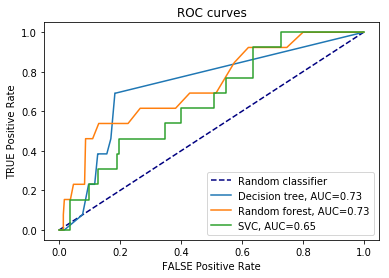

In [61]:
# Decision tree
y_pred_dt = dec_tree.predict_proba(X_test.values)[:, 1]
fpr_dt, tpr_dt, _ = metrics.roc_curve(y_test.astype(int), y_pred_dt)
auc_dt = metrics.auc(fpr_dt, tpr_dt)

# Random forest
y_pred_rf = rf_clf.predict_proba(X_test.values)[:, 1]  # proba for positive class
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test.astype(int), y_pred_rf)
auc_rf = metrics.auc(fpr_rf, tpr_rf)

# Support vector classifier
y_pred_svc = svc_clf.predict_proba(X_test.values)[:, 1]
fpr_svc, tpr_svc, _ = metrics.roc_curve(y_test.astype(int), y_pred_svc)
auc_svc = metrics.auc(fpr_svc, tpr_svc)

plt.figure()
# reference line for random classifier
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = 'Random classifier')
plt.plot(fpr_dt, tpr_dt, label='Decision tree, AUC={:.2f}'.format(auc_dt))
plt.plot(fpr_rf, tpr_rf, label='Random forest, AUC={:.2f}'.format(auc_rf))
plt.plot(fpr_svc, tpr_svc, label='SVC, AUC={:.2f}'.format(auc_svc))
plt.xlabel('FALSE Positive Rate')
plt.ylabel('TRUE Positive Rate')
plt.title('ROC curves')
plt.legend(loc='lower right')
plt.show()

## Milestone 2 Summary <a id='summary2'></a>

I built three models - a Decision Tree, a Random Forest, and an SVC, to predict faulty products, that is the rare positive class in the dataset. I have commented out some code in the notebook and hard-coded the results of calculations because otherwise the execution time is too long.

Parameters for the models were found by grid search.

The ability of the models to correctly predict the rare class on the testing data is very low. The Decision Tree has recall of 0.38 (by correctly predicting 5 positive cases out of 13), while both the Random Forest and the SVC fail to predict correctly any positive cases. 

As can be seen on the ROC curve chart above, the areas under curve of all the three models are not very different from each other and the curves are only slightly higher than the reference line for a random classifier.

I suppose there can be many reasons for this poor performance, from methodological errors to the inappropriateness of the data itself.

[Back to top](#top)

# Milestone 3

## Simple Neural Networks Model - Single-layer Perceptron <a id='slp'></a>

Useful links:

https://www.tensorflow.org/guide/keras

https://keras.io/getting-started/sequential-model-guide/

Multilayer Perceptron (MLP) for binary classification

https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

In [62]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

A reminder regarding the shape of my data:
```
X_train (2324, 90) <class 'numpy.ndarray'>
y_train (2324,) <class 'numpy.ndarray'> Counter({0: 1162, 1: 1162})
X_test (314, 90) <class 'pandas.core.frame.DataFrame'>
y_test (314,) <class 'numpy.ndarray'> Counter({0: 301, 1: 13})
```

A limited grid search can be done as follows:
```python
def create_model():
    """Return a model for grid search."""
    slp_model = keras.models.Sequential([
        keras.layers.Dense(64, input_dim=90, activation='relu'),  # one input layer
        keras.layers.Dropout(0.1),
        keras.layers.Dense(1, activation=tf.nn.sigmoid)           # one output layer
    ])
    
    slp_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'binary_crossentropy'])
    
    return slp_model

model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model)
param_grid = dict(epochs=[20,30,40], batch_size=[10, 20, 40, 60, 80, 100])
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train, verbose=0)
grid_result.best_params_

{'batch_size': 10, 'epochs': 40}
```

In [63]:
def run_slp():
    """Return predictions from a single run of perceptron."""
    slp_model = keras.models.Sequential([
        keras.layers.Dense(64, input_dim=90, activation='relu'),  # one input layer
        keras.layers.Dense(1, activation=tf.nn.sigmoid)           # one output layer
    ])

    slp_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

    slp_model.fit(X_train, 
                  y_train,
                  epochs=40,
                  batch_size=10,
                  validation_split=0.1,
                  verbose=0
                 )

    slp_predictions = slp_model.predict(X_test)
    
    return slp_predictions

In [64]:
# Generate several arrays of predictions -- see results for 10 runs below
slp_predictions = []
num_runs = 1  # make it 1 for submission so that the code runs fast
for i in range(num_runs):
    slp_predictions.append(run_slp())

# Calculate the mean of the predictions
all_predictions = np.concatenate(slp_predictions, axis=1)
slp_pred_df = pd.DataFrame(data=all_predictions,
                           index=np.arange(all_predictions.shape[0]),
                           columns=np.arange(all_predictions.shape[1])
                          )
slp_pred_df['mean'] = np.mean(slp_pred_df.loc[:, :], axis=1)
print(slp_pred_df.head())

# Get classifications
slp_classifications = np.where(slp_pred_df['mean'] >= 0.5, 1, 0)

print('SLP classification report')
print(classification_report(y_test, slp_classifications))

print('SLP confusion matrix')
slp_conf_matrix_obj = confusion_matrix(y_test, slp_classifications)
conf_matrix_slp = pd.DataFrame(slp_conf_matrix_obj,
                              columns = ['Predicted 0', 'Predicted 1'],
                              index = ['True 0', 'True 1']
                             )
conf_matrix_slp

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
              0          mean
0  5.215406e-06  5.215406e-06
1  5.960464e-08  5.960464e-08
2  2.533197e-06  2.533197e-06
3  2.129972e-04  2.129972e-04
4  3.784895e-06  3.784895e-06
SLP classification report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       301
           1       0.05      0.08      0.06        13

    accuracy                           0.90       314
   macro avg       0.51      0.51      0.51       314
weighted avg       0.92      0.90      0.91       314

SLP confusion matrix


,Predicted 0,Predicted 1
True 0,283,18
True 1,12,1


<b>Average results for 10 runs for an SLP model</b>:

                   precision    recall  f1-score   support

               0       0.96      0.95      0.96       301
               1       0.12      0.15      0.13        13

        accuracy                           0.92       314
       macro avg       0.54      0.55      0.54       314
    weighted avg       0.93      0.92      0.92       314

SLP confusion matrix

    Predicted 0	Predicted 1

    True 0	286	15

    True 1	11	2

##  Deep Neural Network (DNN) model - Multilayer Perceptron (MLP) <a id='mlp'></a>

In [65]:
def run_mlp():
    """Return predictions from a single run of MLP."""
    mlp_model = keras.models.Sequential([
        keras.layers.Dense(64, input_dim=90, activation='relu'),  # Input layer
#         keras.layers.Dropout(0.5),                                
        keras.layers.Dense(64, activation='relu'),                # Hidden layer
        keras.layers.Dense(1, activation=tf.nn.sigmoid)           # Output layer
    ])

    mlp_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

    mlp_model.fit(X_train, 
                  y_train,
                  epochs=20,
                  batch_size=32,
                  validation_split=0.1,
                  verbose=0
                 )

    mlp_predictions = mlp_model.predict(X_test)
    
    return mlp_predictions

In [81]:
# Generate several arrays of predictions -- see average results for 10 runs below
mlp_predictions = []
num_runs = 1  # make it 1 for submission so that the code runs fast
for i in range(num_runs):
    mlp_predictions.append(run_mlp())

# Calculate the mean of the predictions
all_predictions_mlp = np.concatenate(mlp_predictions, axis=1)
mlp_pred_df = pd.DataFrame(data=all_predictions_mlp,
                           index=np.arange(all_predictions_mlp.shape[0]),
                           columns=np.arange(all_predictions_mlp.shape[1])
                          )
mlp_pred_df['mean'] = np.mean(mlp_pred_df.loc[:, :], axis=1)
print(mlp_pred_df.head())

# Get classifications
mlp_classifications = np.where(mlp_pred_df['mean'] >= 0.5, 1, 0)

print('MLP classification report')
print(classification_report(y_test, mlp_classifications))

print('MLP confusion matrix')
mlp_conf_matrix_obj = confusion_matrix(y_test, mlp_classifications)
conf_matrix_mlp = pd.DataFrame(mlp_conf_matrix_obj,
                              columns = ['Predicted 0', 'Predicted 1'],
                              index = ['True 0', 'True 1']
                             )
conf_matrix_mlp

              0             1         2             3         4             5  \
0  1.478791e-04  1.648068e-05  0.000016  2.125204e-04  0.000022  4.280508e-04   
1  0.000000e+00  5.960464e-08  0.000000  8.940697e-08  0.000000  0.000000e+00   
2  2.564579e-03  2.583861e-05  0.008973  1.657605e-04  0.000181  6.854534e-07   
3  5.662441e-07  1.400709e-06  0.003397  5.725026e-05  0.001931  5.453825e-06   
4  1.192093e-07  0.000000e+00  0.000003  3.334880e-05  0.013774  2.834797e-04   

              6             7             8             9          mean  
0  3.039837e-06  2.682209e-07  3.206730e-05  6.526709e-05  9.430051e-05  
1  5.960464e-08  0.000000e+00  1.192093e-07  1.788139e-07  5.066395e-08  
2  6.341934e-05  6.854534e-07  3.081560e-05  4.231930e-06  1.200923e-03  
3  5.203992e-03  1.117885e-04  3.856421e-05  9.199083e-04  1.166731e-03  
4  7.465482e-05  6.347895e-06  4.226565e-04  1.475215e-05  1.461187e-03  
MLP classification report
              precision    recall  f1-score

,Predicted 0,Predicted 1
True 0,285,16
True 1,11,2


<b>Average results for 10 runs of an MLP model</b>

MLP classification report

                      precision    recall  f1-score   support

               0       0.96      0.95      0.96       301
               1       0.12      0.15      0.13        13
    
        accuracy                           0.92       314
       macro avg       0.54      0.55      0.54       314
    weighted avg       0.93      0.92      0.92       314

MLP confusion matrix

    Predicted 0	Predicted 1

    True 0	286	15

    True 1	11	2


## RNN model <a id='rnn'></a>

References re. how to transform data for RNN modeling:

https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [67]:
# Split the data containing the selected features into training & testing 
reduced_prod_df = production_df[final_features_list]
train_X, test_X = reduced_prod_df.iloc[:1200, :], reduced_prod_df.iloc[1200:, :]

In [68]:
# Impute outliers and missing values
train_X, test_X = prepare_data(['impute_outliers', 'impute_missing'],
                               train_X,
                               test_X)
print(train_X.shape, test_X.shape) 

IMPUTING OUTLIERS
Done
IMPUTING OUTLIERS
Done
Number of missing values in training set X: 1144
IMPUTING MISSING VALUES
Number of missing values in training set X: 0
Number of missing values in testing set XX: 640
IMPUTING MISSING VALUES
Number of missing values in testing set XX: 0
(1200, 90) (367, 90)


In [69]:
# z-scale the training and the testing sets
scaler = StandardScaler()
scaler.fit(train_X)  # Fit to training set X
train_X = pd.DataFrame(scaler.transform(train_X),
                       index = train_X.index,
                       columns = train_X.columns)
test_X = pd.DataFrame(scaler.transform(test_X),
                      index = test_X.index,
                      columns = test_X.columns)

In [70]:
from pandas import DataFrame
from pandas import concat

# Source: see above

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [71]:
# Tranform data to a format appropriate for RNN
train_X = series_to_supervised(train_X.values, 1, 1)
test_X = series_to_supervised(test_X.values, 1, 1)

In [72]:
# Split labels into training & testing sets
train_y, test_y = production_df.iloc[:1200, -1], production_df.iloc[1200:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(1199, 180) (1200,) (366, 180) (367,)


In [73]:
# Distribution of positive and negative cases in the train and test data
train_y = train_y.astype(int)
mask_neg_outcome_Y = (train_y == -1)  # --> bool array
pos_outcome  = (train_y == 1)
print('Distribution of pass/fail labels in the training set')
print('Pass labels -1:', sum(mask_neg_outcome_Y), 'cases')
print('Fail labels 1:', sum(pos_outcome), 'cases')

test_y = test_y.astype(int)
mask_neg_outcome_y = (test_y == -1)  # --> bool array
pos_outcome  = (test_y == 1)
print('Distribution of pass/fail labels in the testing set')
print('Pass labels -1:', sum(mask_neg_outcome_y), 'cases')
print('Fail labels 1:', sum(pos_outcome), 'cases')

Distribution of pass/fail labels in the training set
Pass labels -1: 1118 cases
Fail labels 1: 82 cases
Distribution of pass/fail labels in the testing set
Pass labels -1: 345 cases
Fail labels 1: 22 cases


In [74]:
# Replace -1 with 0
train_y[mask_neg_outcome_Y] = 0
zero_outcome = (train_y == 0)
pos_outcome  = (train_y == 1)
print('Pass labels 0:', sum(zero_outcome), 'cases')
print('Fail labels 1:', sum(pos_outcome), 'cases')

test_y[mask_neg_outcome_y] = 0
zero_outcome = (test_y == 0)
pos_outcome  = (test_y == 1)
print('Pass labels 0:', sum(zero_outcome), 'cases')
print('Fail labels 1:', sum(pos_outcome), 'cases')

Pass labels 0: 1118 cases
Fail labels 1: 82 cases
Pass labels 0: 345 cases
Fail labels 1: 22 cases


In [75]:
# To arrays
train_X, train_y = train_X.values, train_y.values
test_X, test_y = test_X.values, test_y.values
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(1199, 180) (1200,) (366, 180) (367,)


In [76]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(1199, 1, 180) (1200,) (366, 1, 180) (367,)


In [77]:
# Check data structure types
[type(i) for i in (train_X, train_y,  test_X, test_y)] 

[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]

In [78]:
# Delete the first rows in y-sets corresponding to the removed rows with NaN values 
# in the x-sets because of the pd.shift operation
# train_X = np.delete(train_X, (0), axis=0)  # already deleted
train_y = np.delete(train_y, (0), axis=0)
# test_X = np.delete(test_X, (0), axis=0)  # already deleted
test_y = np.delete(test_y, (0), axis=0)

In [79]:
def run_rnn():
    """Return predictions from a single run of RNN."""
    rnn_model = keras.models.Sequential()
    rnn_model.add(keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    rnn_model.add(keras.layers.Dropout(0.2))
    #    model.add(keras.layers.LSTM(70))
    #    model.add(keras.layers.Dropout(0.3))
    rnn_model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

    # rnn_model.compile(loss='mean_squared_error', optimizer='adam')

    rnn_model.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['accuracy', 'binary_crossentropy'])
    rnn_model.fit(train_X,
                  train_y,
                  epochs=4,
                  batch_size=70, 
#                     validation_data=(test_X, test_y),
                  validation_split=0.1,
                  verbose=2,
                  shuffle=False)
    rnn_predictions = rnn_model.predict(test_X)
    return rnn_predictions

In [80]:
# Generate several arrays of predictions -- see average results for 10 runs below
rnn_predictions = []
num_runs = 1  # make it 1 for submission so that the code runs fast
for i in range(num_runs):
    rnn_predictions.append(run_rnn())

# Calculate the mean of the predictions
all_predictions_rnn = np.concatenate(rnn_predictions, axis=1)
rnn_pred_df = pd.DataFrame(data=all_predictions_rnn,
                           index=np.arange(all_predictions_rnn.shape[0]),
                           columns=np.arange(all_predictions_rnn.shape[1])
                          )
rnn_pred_df['mean'] = np.mean(rnn_pred_df.loc[:, :], axis=1)
print(rnn_pred_df.head())

# Get classifications
rnn_classifications = np.where(rnn_pred_df['mean'] >= 0.5, 1, 0)
print('RNN classification report')
print(classification_report(test_y, rnn_classifications))

print('RNN confusion matrix')
rnn_conf_matrix_obj = confusion_matrix(test_y, rnn_classifications)
conf_matrix_rnn = pd.DataFrame(rnn_conf_matrix_obj,
                               columns = ['Predicted 0', 'Predicted 1'],
                               index = ['True 0', 'True 1']
                              )
conf_matrix_rnn

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 1079 samples, validate on 120 samples
Epoch 1/4
 - 1s - loss: 0.7079 - acc: 0.4940 - binary_crossentropy: 0.7079 - val_loss: 0.8576 - val_acc: 0.0667 - val_binary_crossentropy: 0.8576
Epoch 2/4
 - 0s - loss: 0.5637 - acc: 0.8109 - binary_crossentropy: 0.5637 - val_loss: 0.7513 - val_acc: 0.2583 - val_binary_crossentropy: 0.7513
Epoch 3/4
 - 0s - loss: 0.4788 - acc: 0.9231 - binary_crossentropy: 0.4788 - val_loss: 0.6541 - val_acc: 0.6833 - val_binary_crossentropy: 0.6541
Epoch 4/4
 - 0s - loss: 0.4017 - acc: 0.9286 - binary_crossentropy: 0.4017 - val_loss: 0.5659 - val_acc: 0.9000 - val_binary_crossentropy: 0.5659
          0      mean
0  0.460808  0.460808
1  0.486073  0.486073
2  0.397704  0.397704
3  0.431037  0.431037
4  0.359273  0.359273
RNN classification report
              precision    recall  f1-score   support

           0       0.94      0.99      0.

,Predicted 0,Predicted 1
True 0,342,2
True 1,22,0


<b>Average results for 10 runs of the RNN model</b>
```
RNN classification report

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       344
           1       0.00      0.00      0.00        22

    accuracy                           0.94       366
   macro avg       0.47      0.50      0.48       366
weighted avg       0.88      0.94      0.91       366

RNN confusion matrix

Predicted 0	Predicted 1
True 0	344	0
True 1	22	0
```

## Milestone 3 summary <a id='summary3'></a>

In this part, I built three models - a simple perceptron model, a multi-layer perceptron and a recurrent neural network model (RNN). The RNN model required futher data processing in addition to that done in Milestone 1. 

All models perform very badly on the testing data by almost completely failing to predict correctly the rare positive class targets.

Compared to the other models, only the Decision Tree model looks promising. 

In general,  based on the results of these models, I think it is not possible to draw any relevant conclusions about the relationship of the features and the product quality. 